# Regresná analýza

Po skončení kapitoly budete vedieť:

- TBD

https://www.kdnuggets.com/2019/03/beginners-guide-linear-regression-python-scikit-learn.html

Podrobnejšie informácie o regresnej analýze možno nájsť napríklad v knihe *[James, G. et al. (2017) An Introduction to Statistical Learning. Springer.](http://faculty.marshall.usc.edu/gareth-james/ISL/)*.

## Porozumenie problematike

## Import potrebných modulov a funkcií

Začneme ako obyčajne importom potrebných modulov. S väčšinou modulov sa opakovane stretávame, preto ich nie je potrebné bližšie predstaviť. Module *patsy* zjednodušuje zápis modelu. Funkcie *plot_corr* a *train_test_split* sme importovali z *statsmodels.graphics.correlation* a *sklearn.model_selection*. 

In [94]:
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import pandas as pd
import numpy as np
import patsy
from statsmodels.graphics.correlation import plot_corr
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')

Tak ako sme zvyknutí, nahráme dátový súbor do datasetu knižnice *Pandas*.

In [1]:
dataset = pd.read_csv('kurz02.csv')

NameError: name 'pd' is not defined

Na začiatku sa oboznámime s dátami pomocou dobre známej funkcie *head()*.

## Porozumenie dátam

In [96]:
dataset.head() 

pristupy  testy  skuska  projekt  zadania  vysledne_body vysledna_znamka
0      1354   41.5    14.0    88.40     40.0         162.21               C
1       360   24.0     0.0    82.33      7.0          96.40              FX
2       849   49.0    16.0    79.79     40.0         169.54               B
3       173   41.0    18.0    83.16      0.0         118.23              FX
4       478    7.0     0.0     0.00     10.0          21.67              FX

Odstránime z datasetu prípadné prázdne a duplicitné hodnoty.

## Predspracovanie dát

In [97]:
dataset2 = dataset.dropna()

In [98]:
dataset2 = dataset2.drop_duplicates()

Teraz sa podrobnejšie oboznámime s jednotlivými stĺpcami datasetu. 

In [99]:
list(dataset2.columns)

['pristupy',
 'testy',
 'skuska',
 'projekt',
 'zadania',
 'vysledne_body',
 'vysledna_znamka']

Stĺpce v prípade potreby premenujeme, aby sme mohli výsledky ľahšie interpretovať. Na premenovanie polí použijeme druhý dataset.

Poznanie dátových typov jednotlivých stĺpcov datasetu je nevyhnuntým predpokladom pre úspešnú aplikáciu akéhokoľvek modelu. Pomocou funkcie *info()*, zobrazíme počet riadkov datasetu. Navyše vidíme, či niektorý zo stĺpcov obsahuje prázdne hodnoty (*non-null*) ako aj dátové typy jednotlivých stĺpcov.

In [100]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 7 columns):
pristupy           62 non-null int64
testy              62 non-null float64
skuska             62 non-null float64
projekt            62 non-null float64
zadania            62 non-null float64
vysledne_body      62 non-null float64
vysledna_znamka    62 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 3.9+ KB


V rámci porozumenia dátam vypočítame základné popisné štatistiky dátového súboru pomocou funkcie *describe()*. Parameter *include* špecifikuje dátové typy, pre ktoré sa majú popisné štatistiky zobraziť. Zmysel má väčšinou použiť iba číselné dátové typy. Tabuľku sme nakoniec transponovali pre prehľadnejšie zobrazenie dát pomocou funkcie *.T*. 

In [101]:
dataset2.describe(include=[np.number]).T

count        mean         std   min       25%     50%  \
pristupy        62.0  985.048387  414.657252  28.0  691.7500  961.00   
testy           62.0   40.112903   13.015885   0.0   35.2500   43.50   
skuska          62.0   13.177419    4.880621   0.0   13.0000   14.00   
projekt         62.0   81.230000   25.512808   0.0   82.1275   89.58   
zadania         62.0   31.693548   11.148166   0.0   28.5000   36.00   
vysledne_body   62.0  147.286613   43.066892   0.0  135.9725  162.07   

                     75%      max  
pristupy       1178.5000  2135.00  
testy            49.0000    57.00  
skuska           16.0000    20.00  
projekt          93.7475    99.48  
zadania          40.0000    40.00  
vysledne_body   175.8125   189.92

## Modelovanie

Údaje z datasetu rozdelíme na trénovaciu a testovaciu množinu pomocou funkcie *train_test_split*. Na testovanie môžeme vyčleniť napríklad 30% dát parametrom *test_data_size*. Aby sme mohli výpočet reprodukovať, nastavíme *seed* pre generátor náhodných čísel, napr. na 10.

In [102]:
X = dataset2[['projekt','zadania','pristupy','skuska','testy']]
y = dataset2[['vysledne_body']]
seed = 10 
test_data_size = 0.3 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_data_size, random_state = seed)
train_data = pd.concat([X_train, y_train], axis = 1)
test_data = pd.concat([X_test, y_test], axis = 1)

Teraz vypočítame maticu korelačných koeficientov pre číselné dátové stĺpce trénovacej množiny. Matica je symestrická podľa ľavej diagonály. Na diagonále je zobrazená korelácia premennej so samou sebou, je preto prirodzené, že sa rovná 1 a nie je vhodná pre ďalšiu analýzu. 

In [103]:

corrMatrix = train_data.corr(method = 'pearson')
corrMatrix

projekt   zadania  pristupy    skuska     testy  vysledne_body
projekt        1.000000  0.801389  0.467812  0.557367  0.666989       0.899312
zadania        0.801389  1.000000  0.648714  0.629827  0.667937       0.876565
pristupy       0.467812  0.648714  1.000000  0.528425  0.492659       0.578795
skuska         0.557367  0.629827  0.528425  1.000000  0.863221       0.790099
testy          0.666989  0.667937  0.492659  0.863221  1.000000       0.907615
vysledne_body  0.899312  0.876565  0.578795  0.790099  0.907615       1.000000

Najbežnejšou metódou merania korelácie medzi dvomi číselnými hodnotami je Pearsonov korelačný koeficient. Ten sme použili i my ako parameter funkcie *corr()*. Zopakujme si, čo znamenajú jednotlivé hodnoty korelačného koeficientu (*r*), ktorý nadobúda hodnoty z intervalu <-1,1>. Ak je *r* = 1, obe premmené *x* a *y*, spolu ideálne rastú aj klesajú v rovnakom smere. V prípade, ak *r* = -1, je tento smer opačný, ak rastie *x*, klesá *y*. Ak je *r* = 0, medzi premennými *x* a *y* nie je lineárna závislosť.
V bežných podmienkach nie je koeficient *r*  rovný 1 alebo -1 bežný. Často postačuje, ak je korelačný koeficient väčší ako 0,6, aby sme vzťah medzi premennými mohli pokladať za lineárny.
Ak medzi uvedenými premennnými nie je lineárna závislosť, neznamená to, že medzi nimi nie sú iné typy závislostí, ktoré ale nemôžeme vyjadriť jednoduchou čiarou.

Výsledok zobrazíme pomocou tepelnej mapy korenačných koeficientov. Pomocou farebnej škály tak hneď vidíme, aký silný pozitívny alebo negatívny vzťah medzi jednotlivými dvojicami premenných existuje.

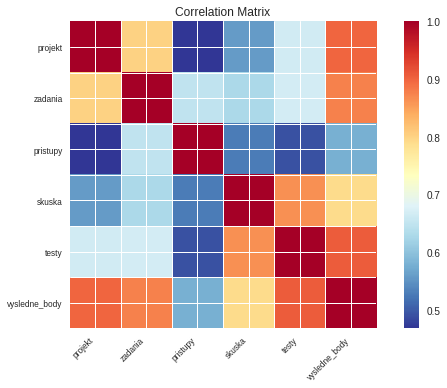

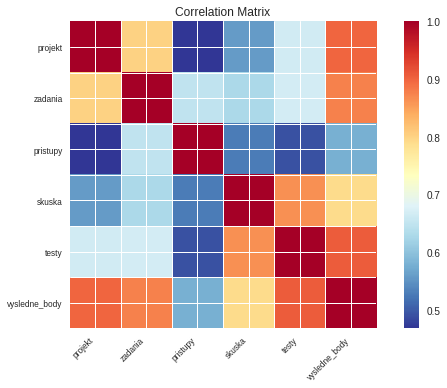

In [104]:
xnames=list(train_data.columns)
ynames=list(train_data.columns)
plot_corr(corrMatrix, xnames=xnames, ynames=ynames,\
          title=None, normcolor=False, cmap='RdYlBu_r')

V zobrazenej mape vidíme mieru korelácie medzi jednotlivými premennými. Na základe nej sa môžeme rozhodnúť, medzi ktorými premennými existuje lineárny vzťah, a teda ktoré premenné sú vhodným adeptom pre ďalšiu regresnú analýzu. 

Okrem mapy korelačných koeficientov môžeme použiť graf rozptylu, v ktorom zobrazíme aj lineárnu čiaru regresie. Použijeme na to funkcie *subplots* modulu *matplotlib* a funkciu *regplot* z modulu *seaborn*. Funkcia očakáva nasledujúce argumenty:

- nezávislá premenná *x*,
- závislá premenná *y*,
- interval spoľahlivosti regresného parametra *ci* z intervalu <0,100>,
- dataset, ktorý obsahuje trénovaciu množinu, 
- objekt grafu typu *matplotlib*, označený ako *ax*,
- popis osí x a y,
- veľkosť zobrazenia plátna, na ktorom sa graf vykreslí,
- iné nastavenia vzhľadu.

In [2]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='testy', y='vysledne_body', ci=95,
data=train_data, ax=ax, color='k', scatter_kws={"s": 20, "color":"royalblue", "alpha":1})
ax.set_ylabel('vysledne body', fontsize=15, fontname='DejaVu Sans')
ax.set_xlabel("testy", fontsize=15, fontname='DejaVu Sans')
ax.set_xlim(left=None, right=None)
ax.set_ylim(bottom=None, top=None)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()

NameError: name 'plt' is not defined

## Model jednoduchej lineárnej regresie

Na grafe vidíme čiaru, ktorá charakterizuje vzťah medzi nezávislou a závislou premennou. Teraz by nás zaujímalo, ako vyzerá rovnica, ktorá by túto priamku charakterizovala. Použijeme na to funkcie z modulu *Statsmodels*. Tento modul nám umožní spolu s modulom *patsy* jednoducho definovať viaceré regresné modely a  experimentovať s nimi pri hľadaní najvhodnejšieho modelu.  

Definujeme model lineárnej regresie a priradíme ho k premennej *linearModel*.

In [106]:
linearModel = smf.ols(formula='vysledne_body ~ projekt', data=train_data)

Použijeme funkciu *ols*, kde ako argument použijeme vzorec vytvorený pomocou špeciálneho modulu *patsy*, ktorý zjednodušuje zápis vzťahov medzi nezávislými a závislými premennými pomocou znaku ~. V argumente *data* uvedieme, kde tieto premenná funkcia nájde, v našom prípade to bude opäť trénovacia množina dát *train_data*.

Teraz môžeme zavolať metódu *fit()* a výsledok priradiť do premennej *linearModelResult*. Táto metóda prispôsobí model lineárnej regresie dátam, teda snaží sa odhadnúť regresné koeficienty metódou najmenších štvorcov.

In [107]:
linearModelResult = linearModel.fit()

Konečne môžeme vizualizovať všetky dôležité charakteristiky modelu pomocou metódy *summary()*. 

In [108]:

print(linearModelResult.summary())

                            OLS Regression Results                            
Dep. Variable:          vysledne_body   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     173.4
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           2.56e-16
Time:                        08:06:20   Log-Likelihood:                -188.00
No. Observations:                  43   AIC:                             380.0
Df Residuals:                      41   BIC:                             383.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.8132      9.413      3.061      0.0

### Analýza výsledkov

Metóda *fit()* poskytuje množstvo funkcií, ktorými môžeme preskúmať jej výstupy. Najužitočnejšia je práve funkcia *summary()*, ktorá umožňuje zorbaziť parametre modelu, intervaly spoľahlivosti, p-values a t-values.  

V ľavom hornom rohu nájdeme informácie o závislej premennej modelu. Vpravo sa nachádzajú ďalšie charakteristiky modelu, ktoré hovoria o jeho kvalite, napríklad *R-squared* - koeficient determinancie. Táto štatistika predstavuje mieru variability závislej premennej, ktorú vie nami vytvorený model vysvetliť.

Vľavo teda vidíme, že závislá premenná modelu *Dep. Variable* je *vysledne_body*. Štatistika *R-squared* nadobúda hodnotu 0.809, t.j. 81%. Táto charakteristika hovorí, do akej vieme popísať variabilitu závislej premennej v navrhnutom modeli. Náš model teda dostatočne dobre popisuje 80% všetkých hodnôt závislej premennej.    

V časti *coef* vidíme práve hľadané koeficienty, ktoré charakterizujú priamku lineárnej regresie. Koeficient *Intercept* predstavuje hodnotu, v ktorej priamka pretína y-ovú os. Druhý koeficient spolu so znamienkom pri nezávislej premennej charakterizuje sklon priamky.

Výsledná priamka, ktorá charakterizuje vzťah medzi nezávislou premennou *projekt* a závislou premennou *vysledne_body* má tvar *y* = 1,465 \* *projekt* + 28.8132. 

Ak sa pozrieme na to, či nami navrhnutý model modeluje vzťah medzi premennými, skúmame jeho štatistickú významnosť. Zaujíma nás výsledok F-testu, ktorý je v sumarizačnej tabuľke vyjadrený hodnotou *F-statistic*. Túto hodnotu považujeme za dobrú, ak je väčšia ako 1. V našom prípade sa rovná 173.4. Zároveň platí, že hodnota pravdepobonosti *Prob (F-statistic)* = 2.56e-16 je menšia ako zvolená hodnota hladiny významnosti 0.05. Môžeme preto konštatovať, že riziko, že sme omylom zamietli nulovú hypotézu a model nie je štatistiky významný, je menej ako stanovených 5%. Inými slovami, náš model je štatisticky významný na zvolenej 95% hladine spoľahlivosti.  

Keď sme overili, že náš model je štatisticky významný vo všeobecnosti, musíme ešte overiť štatistickú významnosť jednotlivých nezávislých premenných modelu. Budeme si všímať hodnotu*p-values* v sumarizačnej tabuľke označenej ako *p>|t|*. Opäť budeme porovnávať túto hodnotu pri jednotlivých nezávislých premenných so zvolenou hladinou významnosti $\alpha$ = 0.05. Ak je hodnota *p-value* pre danú premmennú menšia ako 0.05, je zvolená premenná štatisticky významná pre náš model a prispieva k vyjadreniu variability nezávislej premennej. Opačne, ak je väčšia, premená nie je štatisticky výzanmná a mala by byť z modelu odstránená.
V našom modeli sú obe zvolené nezávislé premenné štatisticky významné.

## Model viacnásobnej lineárnej regresie

V predchádzajúcich príkladoch modelov lineárnej regresie sme modelovali vzťah vybranej nezávislej a závislej premennej. V reálnych podmienkach sa však často stretneme s tým, že na závislú premennú má vplyv viacero nezávislých premenných, pričom každá môže na závislú premennú vplývať rôznou váhou. Z toho dôvodu je potrebné preskúmať všetky nezávislé premenné, ktoré môžu priniesť k vysvetleniu variability závislej premennej.
Postup bude veľmi podobný predchádzajúcim modelom s tým rozdielom, že vo vzorci použitom pri vytváraní modelu uvedenie všetky nezávislé premenné, ktoré by mohli mať vplyv na závislu premennú. Tieto premenné sa uvádzajú ako argument funkcie *ols*, pričom sa jedná o symbolický zápis, znamienko + neznanená, že sa premenné aritmeticky ščítajú.

In [109]:
multiLinearModel2 = smf.ols(formula= 'vysledne_body ~ testy + projekt', data=train_data)

Ostatné kroky sú totožné s krokmi, ktoré sme už niekoľkokrát uskutočnili. 

In [110]:
multiLinearModResult = multiLinearModel2.fit()
print(multiLinearModResult.summary())

                            OLS Regression Results                            
Dep. Variable:          vysledne_body   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     951.3
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           1.88e-34
Time:                        08:06:21   Log-Likelihood:                -140.08
No. Observations:                  43   AIC:                             286.2
Df Residuals:                      40   BIC:                             291.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8192      3.438      0.820      0.4

Vidíme, že pridaním ďalšej nezávislej premennej *testy* sa koeficient determinancie *R-sqaured* zvýšil až na hodnotu *0.979*. Keďže ale tento koeficient prirodzene rastie s počtom nezávislých premmených, aj keď táto novo pridaná premenná nemá silnú koreláciu s nezávislou premennou, je potrebné sledovať charakteristiku *Adj. R-squared*. Táto charakteristika rastie len v prípade, ak pridaná nezávislá premenná skutočne prispieva k vysvetleniu variability modelu. Keďže jej hodnota je v našom modeli tiež vysoká, 0.978, môžeme povedať, že obe nezávislé premenné vysvetľujú variabilitu nezávislej premennej až na 98%. Výsledný vzťah má tvar:
*y* = 0.8626 \* *projekt* + 1.8704 \* *testy* + 2.8192.

## Hľadanie najvhodnejšieho modelu pomocou lineárnej regresie

Kombináciou viacnásobnej lineárnej regresie a ďalšími matematickými úpravami môžeme získať model, ktorý najlepšie vysvetľuje variabilitu závislej premennej. Výsledok môže vyzerať ako v nasledujúcom príklade. Musíme si však uvedomiť zvýšené riziko preučenia. 

In [111]:
multiLinearModel5 = smf.ols(formula= 'vysledne_body ~ testy + zadania + projekt + skuska + pristupy', 
data=train_data)
multiLogLinModResult = multiLinearModel5.fit()
print(multiLogLinModResult.summary())

                            OLS Regression Results                            
Dep. Variable:          vysledne_body   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.794e+09
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          5.07e-154
Time:                        08:06:21   Log-Likelihood:                 191.52
No. Observations:                  43   AIC:                            -371.0
Df Residuals:                      37   BIC:                            -360.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0021      0.002      1.283      0.2

V prípade, že do modelu zahrnieme všetky dostupné nezávislé premenné, vidíme, že navrhutý model je štatisticky významný (*Adj. R-squared* = 1.00, *F-statistic* =  1.794e+09 nadobúda veľké hodnoty, zatiaľ čo *Prob (F-statistic)* sa blíži k nule). Na druhej strane vidíme, že nezávislá premenná *pristupy* nie je štatisticky významná (*p>|t|* = 0.766) a mala by byť z modelu odstránená.

## Predpoklady pre použitie regresnej analýzy

Použitie metódy lineárnej regresie vyžaduje splnenie niekoľkých predpokladov. Ak nie sú tieto predpoklady splnené, výsledky regresnej analýzy môžu byť zavádzajúce alebo úplne nesprávne. Preto je potrebné vždy skontrolovať, či nie sú nasledujúce predpoklady porušené:

1. Vzťah medzi závislou a nezávislou premennou musí byť lineárny. V prípade viacnásobnej lineárnej regresie musí vážená suma nezávislých premmených vedieť vysvetliť variabilitu závislej premennej.
2. Reziduá musia mať normálne rozdelenie.
3. Reziduá musia mať konštantnú odchýľku (homoskedasticity).
4. Reziduá nesmú korelovať (autocorrelation).
5. Nesmie existovať korelácia medzi nezávislými premennými. Ak korelujú, hovoríme o multikolinearite (multicollinearity). V takomto modeli závisia koeficienty na existencii inej nezávislej premennej. 

## Vysvetlenie výsledkov regresnej analýzy

Ako sme už zdôraznili, cieľom regresnej analýzy je nájsť model, ktorý bude najlepšie vysvetľovať varaibilitu pozorovanej závislej premennej. Na jej kvantitatívne vyjadrenie môžeme použiť štatistiku *R-squared* (R2). Čo hodnota R2 znamená?
R2 je podieľom dvoch charakteristík:

- Total Sum of Squares (TSS), ktorá predstavuje celkový rozptyl závislej premennej od jej priemernej hodnoty 
- Regression Sum of Squares (RSS) predstavuje celkovú variabilitu závislej premennej, ktorú vie náš model vysvetliť. 

V prípade ideálneho modelu bez chýb v predikcii sa budú obe tieto charakteristiky rovnať, t.j. model bude pokrývať všetku premenlivosť v dátach závislej premennej vzhľadom na jej priemernú hodnotu. V skutočnosti je vždy RSS menšia ako TSS. Tento rozdiel označujeme ako Error Sum of Square (ESS). ESS predstavuje istú mieru variability závislej premennej, ktorú nevieme našim modelom vysvetliť.
Ak používame jednoduchú lineárnu regresiu s jednou nezávislou premennou, R2 dostatočne presne vyjadruje, ako dobre model modeluje získané dáta.
Iná situácia nastane v prípade viacnásobnej lineárnej regresie, pretože R2 citlivo reaguje na pridanie ďalšej nezávislej premennej do modelu, dokonca aj v prípade, ak táto premenná koreluje iba mierne so závislou premennou. Pridanie nezávislej premennej spôsobí prirodzené zvýšenie R2, čo môže viesť k snahe pridávať do modelu automaticky viac nezávislých premenných. Tým však riskujeme overfitting.
Upravená štatistika *Adjusted R2* predstavuje riešenie tohto problému. Jej hodnota sa zvýši len v prípade, že pridaná nezávislá premenná skutočne prispieva k lepšiemu vysvetleniu premenlivosti hodnôt závislej premennej.

V našom príklade prirodzene platí, že ak zohľadníme vplyv všetkých nezávislých premenných na výsledné bodové hodnotenie, priblížime sa k 100%.

## Validácia modelu

Vidíme teda, že aplikácia regresnej analýzy predstavuje iteratívny proces hľadania vhodného modelu, aj pomocou charakteristík *R-squared* a *Adj. R-squred*.
Obe tieto charakteristiky poskytujú odhad, aký silný j vzťah medzi modelom a závislou premennou. 

To však nie je všetko, pretože potom, ako vhodný model nájdeme, musíme model formálne štatisticky overiť. Inými slovami, chceme zistiť, či model modeluje len dáta v našom datasete alebo skutočne poskytuje vysvetlenie skúmaného problému vo všeobecnosti. Môžeme na to použiť niektorú z osvedčených štatistických testov hypotéz.
Ak má teda nejaká nezávislá premenná vzťah so závislou premennou v našom modeli, musí mať nenulový koeficient *$\beta$* (môže byť kladný alebo záporný). V tej chvíli by sme mali overiť, či tento koeficient bude existovať, aj keď použijeme dáta z rovnakej domény, ale z iného obdobia alebo platí len pre aktuálne použité dáta. ďalej musíme zistiť, či sme tento koeficient nenašli iba náhodou. Práve to sú otázky, na ktoré dostaneme odpoveď pomocou testov hypotéz. Hoci hypotézy nám nedajú stopercentnú záruku, že sme koeficient neurčili náhodou, vieme vďaka nim povedať, na akej hladine významnosti bude platiť, že koeficient nie je náhodný.

Začnime teda tým, že si dohodneme výšku rizika, že sme koeficient $\beta$ našli náhodou. Väčšinou sa táto výška rizika označuje ako $\alpha$ a má hodnotu 0.05, resp. 5%. Ak vypočítame 1-$\alpha$, získame mieru úrovne spoľahlivosti, že sme nenulový koeficient $\beta$ v našej analýze nenašli náhodou. Naša úroveň spoľahlivosti je 95% na 5% hladine $\alpha$.   

Teraz môžeme vypočítať pravdepodobnosť (*p-value*) zodpovedajúcu nami nájdenému koeficientu $\beta$ v našom modeli so stanovenou hodnotou spoľahlivosti 1-$\alpha$. Ak je pravdepodobnosť menšia ako stanovená hodnota, odmietame hypotézu, že koneficient $\beta$ bol určený náhodou. Inými slovami, koeficient $\beta$ je štatisticky významný a zamietame nulovú hypotézu. 

### F-test

F-test použijeme na overenie štatickej významnosti medzi modelom a závislou premennou. Ak je hodnota *p-value* V F-teste menšia ako zvolená hladina významosti $\alpha$, zamietame nulovú hypotézu, a teda model je štatisticky významný. V sumarizačnej tabuľke si všímame hodnotu *F-value*, ktorá sa zvyšuje spolu s *R2*. Hľadáme taký model, aby *F-value* bolo väčšie ako 1. Zároveň vidíme, že charakteristika *Prob (F-statistic)* sa blíži k nule, čo znamená, že riziko, že sme hypotézu zamietli omylom, je menej ako 5%. Inými slovami, v tomto prípade je náš model štatisticky významný na hladine významnosti 95%.

### t-test

Akonáhle vieme, že náš model je štatisticky významný vo všeobecnosti, môžeme skúmať štatistickú významnosť nezávislých premenných v ňom. Budeme si všímať hodnotu charakteristiky *p-values* jednotlivých nezávislých premenných zo sumarizačnej tabuľky. V nej si všímame stĺpec p>|t|. Opäť porovnáme aktuálnu hodnotu *p-value* s hladinou významnosti alfa = 0.05. Ak má nezávislá premenná hodnotu *p-value* menšiu ako 0.05, je táto premenná štatisticky významná a prispieva k vysvetleniu variability závislej premennej. Naopak, ak je rovná alebo väčšia, premenná nie je štatisticky významná a môže byť z modelu odstránená. 

## Predikcia hodnoty spojitej závislej premennej

Keď máme model vytvorený

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [113]:
X2 = dataset2[['projekt','zadania','skuska','testy']]
y = dataset2[['vysledne_body']]
seed = 10 
test_data_size = 0.3 
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = test_data_size, random_state = seed)
train_data = pd.concat([X_train, y_train], axis = 1)
test_data = pd.concat([X_test, y_test], axis = 1)

In [114]:
regressor = LinearRegression()

In [115]:
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [116]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[0.00218585]
[[6.00014257e-01 1.00004975e+00 4.32229007e-04 1.66641881e+00]]


In [123]:
X2.columns

Index(['projekt', 'zadania', 'skuska', 'testy'], dtype='object')

In [118]:
predictions = regressor.predict(X_test)

In [119]:
plt.scatter(y_test,predictions)

In [120]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.0031487155172355884
MSE: 1.4846435055720287e-05
RMSE: 0.0038531071949428407


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


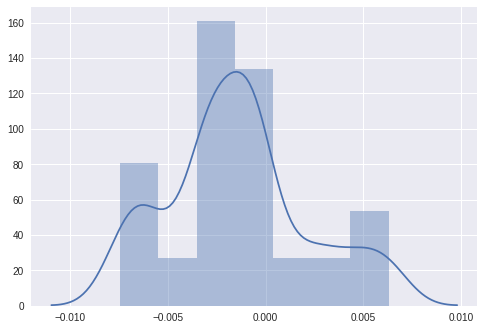

In [121]:
sns.distplot((y_test-predictions));

In [122]:
regressor.score(X_train, y_train)

0.9999999958651864